In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

# !ls 'drive'

# !ls -a 'drive/MyDrive/Cropped_Images'

# Load palm data
# directory = 'drive/MyDrive/new_image_color'
palms = 'drive/MyDrive/TrainingData/Palms_Augmented'
nonpalms = 'drive/MyDrive/TrainingData/NonPalms_Augmented'

# Get a list of all the filenames in the directory
filenames = os.listdir(palms)

print(len(filenames))

Mounted at /content/drive
14420


In [6]:
from PIL import Image
import numpy as np
import os
import re
from google.colab import drive
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split


# Prepare empty lists to store your data and labels
X = []
X4 = []
Y = []
X_filenames = []  # New list to store filenames

# Iterate over folders and files, and load your data
for filename in os.listdir(palms):
      img = Image.open(os.path.join(palms, filename))
      X_filenames.append(filename)  # Save the filename

      #img = img.resize((240, 240))

      # Convert the image to numpy array and separate the channels
      img_array = np.array(img)
      img_rgb = img_array[:, :, :3]  # first three channels (assuming RGB)
      X.append(img_rgb)

      if img_array.shape[2] == 4:  # If the image has a fourth channel
          img_fourth = img_array[:, :, 3]  # fourth channel
          X4.append(img_fourth)

      Y.append('palm')


for filename in os.listdir(nonpalms):
        img = Image.open(os.path.join(nonpalms, filename))
        X_filenames.append(filename)  # Save the filename

        #img = img.resize((240, 240))

        # Convert the image to numpy array and separate the channels
        img_array = np.array(img)
        img_rgb = img_array[:, :, :3]  # first three channels (assuming RGB)
        X.append(img_rgb)

        if img_array.shape[2] == 4:  # If the image has a fourth channel
            img_fourth = img_array[:, :, 3]  # fourth channel
            X4.append(img_fourth)

        # Set the labels
        Y.append('non palm')


# Convert lists to numpy arrays
X = np.array(X)
X4 = np.array(X4)
Y = np.array(Y)

# Convert 'road' to 'non palm' in Y
Y = ['non palm' if y == 'Road' else y for y in Y]

binary_task = True  # Set to False for multiclass task

# Convert all non-'non palm' labels to 'palm' in Y if the task is binary
if binary_task:
    Y = ['palm' if y != 'non palm' else y for y in Y]

# No need to reshape X as we've explicitly resized all images to 40x40
# p is simply the length of X
p = len(X)

# use np.unique to count occurrences of each class
unique, counts = np.unique(Y, return_counts=True)

class_counts = dict(zip(unique, counts))
print(class_counts)  # {'non-palm': 2, 'palm': 4}

{'non palm': 14767, 'palm': 14420}


<ipython-input-6-511cff2571fd>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, X_filenames_train, X_filenames_test = train_test_split(X, Y, X_filenames, test_size=0.2, random_state=42)

In [23]:
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights

# Define the preprocessing with augmentation
preprocess_train = transforms.Compose([
    transforms.Resize(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the preprocessing without augmentation
preprocess_test = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the model
resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Set the model to evaluation mode
resnet18.eval()

# Extract features using ResNet18 for training
X_resnet18_train = []
for img in X_train:
    # Convert the numpy array to PIL Image
    img = Image.fromarray(img.astype('uint8'), 'RGB')

    # Preprocess the image
    img_t = preprocess_train(img)
    img_u = torch.unsqueeze(img_t, 0)

    # Extract features
    with torch.no_grad():  # Deactivates autograd, reducing memory usage and speed up computations
        features = resnet18(img_u)

    X_resnet18_train.append(features.numpy())

# Extract features using ResNet18 for testing
X_resnet18_test = []
for img in X_test:
    # Convert the numpy array to PIL Image
    img = Image.fromarray(img.astype('uint8'), 'RGB')

    # Preprocess the image
    img_t = preprocess_test(img)
    img_u = torch.unsqueeze(img_t, 0)

    # Extract features
    with torch.no_grad():  # Deactivates autograd, reducing memory usage and speed up computations
        features = resnet18(img_u)

    X_resnet18_test.append(features.numpy())

# Reshape the ResNet18 features
X_resnet18_train = np.array(X_resnet18_train).reshape(len(X_resnet18_train), -1)
X_resnet18_test = np.array(X_resnet18_test).reshape(len(X_resnet18_test), -1)

import pickle

# Define the directory
dir_path = "/content/drive/MyDrive/TrainingData"

# Save arrays to .npy files
np.save(os.path.join(dir_path, 'X_resnet18_train.npy'), X_resnet18_train)
np.save(os.path.join(dir_path, 'X_resnet18_test.npy'), X_resnet18_test)
# Save training and testing filenames separately
with open(os.path.join(dir_path, 'filenames_train.pkl'), 'wb') as f:
    pickle.dump(X_filenames_train, f)
with open(os.path.join(dir_path, 'filenames_test.pkl'), 'wb') as f:
    pickle.dump(X_filenames_test, f)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


KeyboardInterrupt: ignored

In [9]:
import pickle

# Define the directory
dir_path = "/content/drive/MyDrive/TrainingData"

# Load arrays from .npy files
X_resnet18_train = np.load(os.path.join(dir_path, 'X_resnet18_train.npy'))
X_resnet18_test = np.load(os.path.join(dir_path, 'X_resnet18_test.npy'))
# Load training and testing filenames separately
with open(os.path.join(dir_path, 'filenames_train.pkl'), 'rb') as f:
    X_filenames_train = pickle.load(f)
with open(os.path.join(dir_path, 'filenames_test.pkl'), 'rb') as f:
    X_filenames_test = pickle.load(f)

KeyboardInterrupt: ignored

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

146/146 [==============================] - 0s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

146/146 [==============================] - 0s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

146/146 [==============================] - 0s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

146/146 [==============================] - 0s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

183/183 [==============================] - 0s 2ms/step
Best model performance (at epoch 92):
Test Accuracy: 98.1500506401062%
Test Kappa: 0.9629932446812445


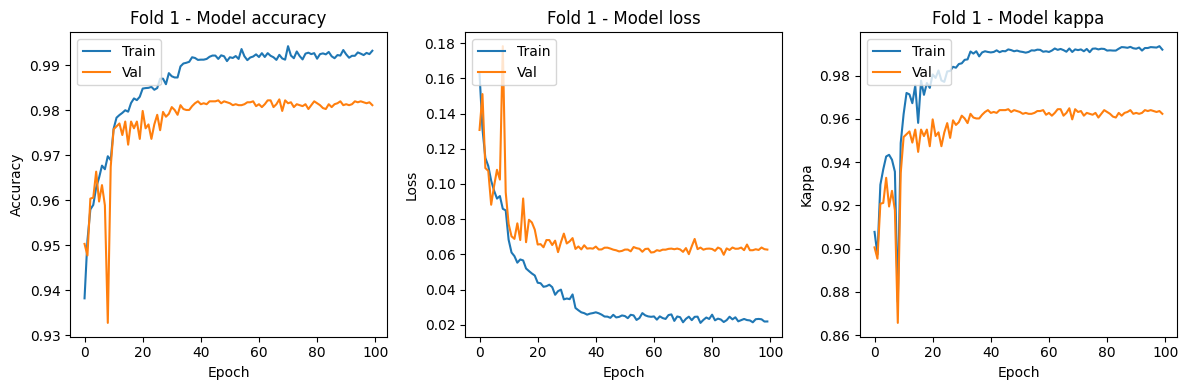

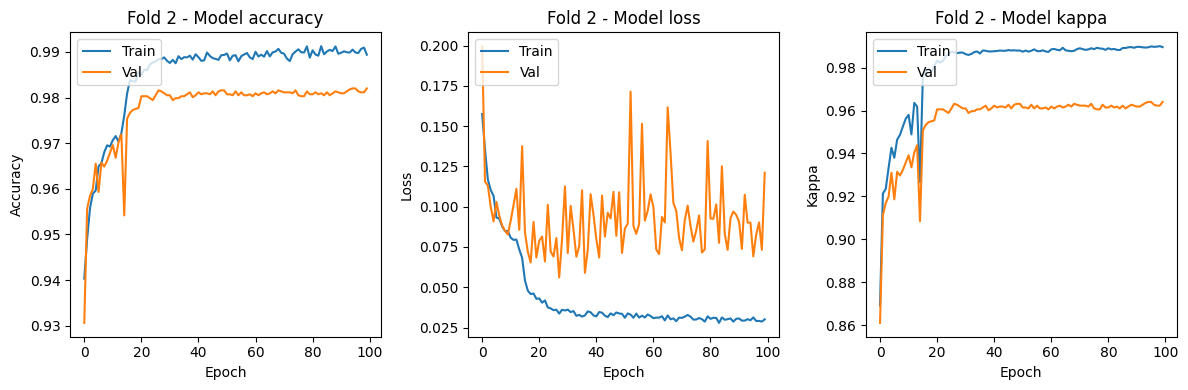

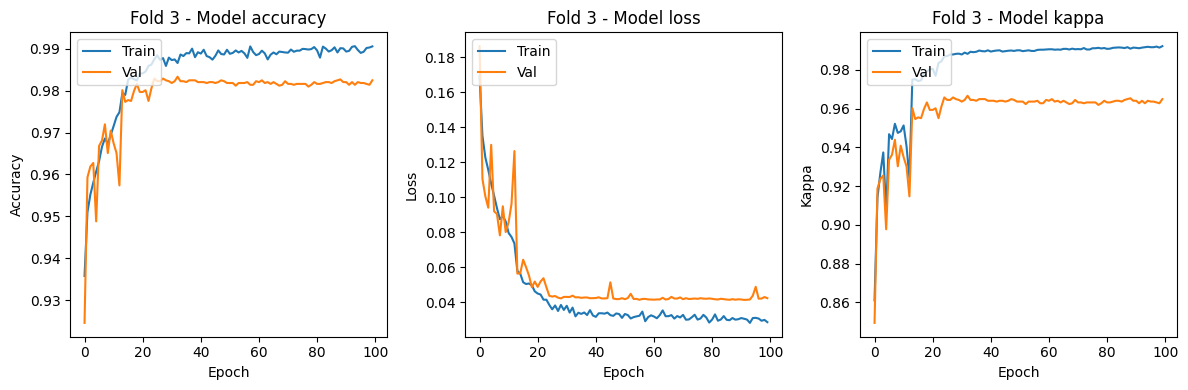

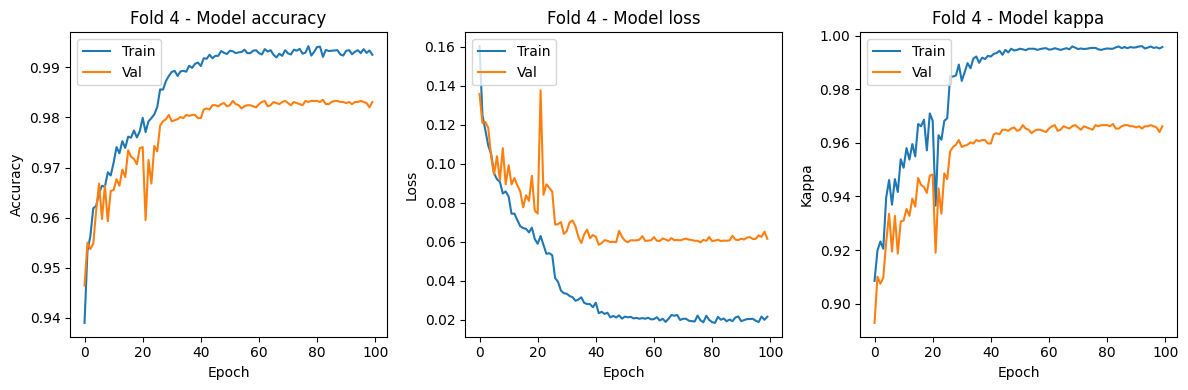

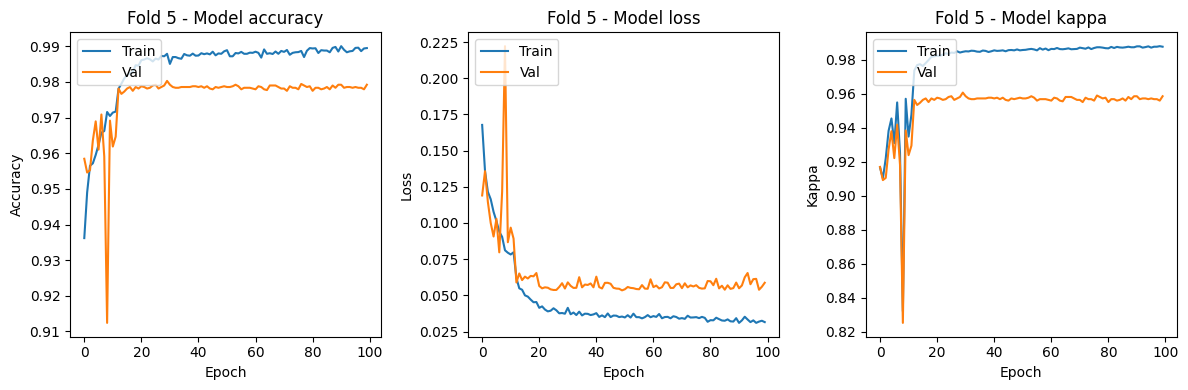

In [10]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import tensorflow as tf

dir_path = "/content/drive/MyDrive/TrainingData"

X_resnet18_train = np.load(os.path.join(dir_path, 'X_resnet18_train.npy'))
X_resnet18_test = np.load(os.path.join(dir_path, 'X_resnet18_test.npy'))

def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_resnet18_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(classes), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

classes = np.sort(np.unique(Y_train))
classes = ['non palm'] + [c for c in classes if c != 'non palm']

le = LabelEncoder()
le.fit(classes)
Y_train_int = le.transform(Y_train)
Y_test_int = le.transform(Y_test)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train_int), y=Y_train_int)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

kfold = StratifiedKFold(n_splits=5, shuffle=True)

fold_no = 1
acc_per_fold = []
kappa_per_fold = []
model_histories = []

best_model = None
best_loss = np.inf
best_epoch = None

class KappaCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        Y_train_pred = self.model.predict(self.X_train, verbose=0)
        train_kappa = cohen_kappa_score(self.y_train, np.argmax(Y_train_pred, axis=-1))
        logs['train_kappa'] = train_kappa
        Y_val_pred = self.model.predict(self.X_val, verbose=0)
        val_kappa = cohen_kappa_score(self.y_val, np.argmax(Y_val_pred, axis=-1))
        logs['val_kappa'] = val_kappa

for train, val in kfold.split(X_resnet18_train, Y_train_int):
    mlp = create_model()
    # Include ModelCheckpoint callback to save weights
    model_save_path = f"fold_{fold_no}_best_weights.h5"
    callbacks = [TqdmCallback(verbose=1),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, mode='min', min_lr=0.00001),
                 ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0),
                 KappaCallback(X_resnet18_train[train], Y_train_int[train], X_resnet18_train[val], Y_train_int[val])]
    history = mlp.fit(X_resnet18_train[train], Y_train_int[train], epochs=100, batch_size=32,
                      validation_data=(X_resnet18_train[val], Y_train_int[val]),
                      class_weight=class_weights_dict, verbose=0, callbacks=callbacks)
    # Load the best weights for this fold
    mlp.load_weights(model_save_path)
    # Evaluate with these weights and save the scores
    scores = mlp.evaluate(X_resnet18_train[val], Y_train_int[val], verbose=0)
    Y_pred = np.argmax(mlp.predict(X_resnet18_train[val]), axis=-1)
    acc_per_fold.append(scores[1] * 100)
    kappa = cohen_kappa_score(Y_train_int[val], Y_pred)
    kappa_per_fold.append(kappa)
    # Save model history for plots
    model_histories.append(history.history)
    # Check if this model is better than previous best
    if np.min(history.history['val_loss']) < best_loss:
        best_loss = np.min(history.history['val_loss'])
        best_model = mlp
        best_epoch = np.argmin(history.history['val_loss']) + 1  # epochs are 1-indexed
    fold_no += 1

# Test the best model on the test data
scores = best_model.evaluate(X_resnet18_test, Y_test_int, verbose=0)
Y_pred = np.argmax(best_model.predict(X_resnet18_test), axis=-1)
test_acc = scores[1] * 100
test_kappa = cohen_kappa_score(Y_test_int, Y_pred)

print(f'Best model performance (at epoch {best_epoch}):')
print(f'Test Accuracy: {test_acc}%')
print(f'Test Kappa: {test_kappa}')

# plot history for accuracy, kappa and loss
for fold_no, history in enumerate(model_histories, 1):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'Fold {fold_no} - Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'Fold {fold_no} - Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot Kappa
    plt.subplot(1, 3, 3)
    plt.plot(history['train_kappa'])
    plt.plot(history['val_kappa'])
    plt.title(f'Fold {fold_no} - Model kappa')
    plt.ylabel('Kappa')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')


    plt.tight_layout()
    plt.show()

# use the best model as the trained MLP
mlp = best_model


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# Calculate the necessary statistics for the training set
Y_train_pred = np.argmax(mlp.predict(X_resnet18_train), axis=-1)
Y_train_scores = mlp.predict(X_resnet18_train)[:, 1]  # Assuming binary classification

# Compute ROC curve and ROC area for training set
fpr_train, tpr_train, _ = roc_curve(Y_train_int, Y_train_scores)
roc_auc_train = roc_auc_score(Y_train_int, Y_train_scores)

# Compute overall accuracy for training set
overall_accuracy_train = accuracy_score(Y_train_int, Y_train_pred)

# Compute average accuracy (mean of class-wise accuracy) for training set
cm_train = confusion_matrix(Y_train_int, Y_train_pred)
class_acc_train = cm_train.diagonal() / cm_train.sum(axis=1)
average_accuracy_train = np.mean(class_acc_train)

# Compute Cohen's kappa for training set
kappa_train = cohen_kappa_score(Y_train_int, Y_train_pred)

# Compute precision and recall for training set
cr_train = classification_report(Y_train_int, Y_train_pred, output_dict=True)
precision_train = cr_train['weighted avg']['precision']
recall_train = cr_train['weighted avg']['recall']

# Generate test metrics
Y_pred = np.argmax(mlp.predict(X_resnet18_test), axis=-1)
Y_scores = mlp.predict(X_resnet18_test)[:, 1] # Assuming binary classification

# Compute ROC curve and ROC area for testing set
fpr, tpr, _ = roc_curve(Y_test_int, Y_scores)
roc_auc = roc_auc_score(Y_test_int, Y_scores)

# Compute overall accuracy
overall_accuracy = accuracy_score(Y_test_int, Y_pred)

# Compute average accuracy (mean of class-wise accuracy)
cm = confusion_matrix(Y_test_int, Y_pred)
class_acc = cm.diagonal() / cm.sum(axis=1)

average_accuracy = np.mean(class_acc)

# Compute Cohen's kappa
kappa = cohen_kappa_score(Y_test_int, Y_pred)

# Compute precision and recall
cr = classification_report(Y_test_int, Y_pred, output_dict=True)
precision = cr['weighted avg']['precision']
recall = cr['weighted avg']['recall']

print(f'Test ROC AUC: {roc_auc}')
print(f'Test Overall Accuracy: {overall_accuracy}')
print(f'Test Average Accuracy: {average_accuracy}')
print(f'Test Kappa: {kappa}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')

183/183 [==============================] - 0s 2ms/step
Test ROC AUC: 0.9984799643454804
Test Overall Accuracy: 0.9815005138746146
Test Average Accuracy: 0.981453217469447
Test Kappa: 0.9629932446812445
Test Precision: 0.9815314077997913
Test Recall: 0.9815005138746146


In [12]:
import pandas as pd

# We will use these lists to store values for each class
class_accuracy = []
correct_counts = []

# We calculate class-wise accuracy and counts for each class
for i in range(len(le.classes_)):
    class_accuracy.append(class_acc[i])
    correct_counts.append(cm[i, i])

# We calculate class-wise accuracy and counts for each class for training set
class_accuracy_train = []
correct_counts_train = []

for i in range(len(le.classes_)):
    class_accuracy_train.append(class_acc_train[i])
    correct_counts_train.append(cm_train[i, i])

# Your "features" here should be a list of features.
# For this case, it's not clear what your features are.
# If each row in your X_resnet18_train corresponds to a feature, you can use this:
# features = [f'feature_{i}' for i in range(X_resnet18_train.shape[1])]
# But from your code it seems like all features are used together in a single model.
# So there should be only one "feature" which is the model itself.
# If so, use this:
features = ['ResNet18_model']

# Convert training accuracy results to dataframe
df_class_accuracy_train = pd.DataFrame(np.array(class_accuracy_train).reshape(-1,1), columns=features)
df_class_accuracy_train['Class'] = le.classes_
df_class_accuracy_train.set_index('Class', inplace=True)

# Convert correct counts to dataframe
df_correct_counts_train = pd.DataFrame(np.array(correct_counts_train).reshape(-1,1), columns=features)
df_correct_counts_train['Class'] = le.classes_
df_correct_counts_train.set_index('Class', inplace=True)

# Compute counts for each class
class_counts_train = pd.Series(Y_train_int).value_counts().sort_index().values

# Create a string representation of fractions
fraction_train = (df_correct_counts_train.astype(str) + '/' + np.array(class_counts_train, dtype=str).reshape(-1, 1)).applymap(lambda x: f'{x}')

# Convert training results to dataframes
df_overall_train = pd.DataFrame({'Feature': features, 'Train OA': [overall_accuracy_train], 'Train AA': [average_accuracy_train], 'Train Kappa': [kappa_train]})
df_precision_recall_train = pd.DataFrame({'Feature': features, 'Train Precision': [precision_train], 'Train Recall': [recall_train]})

# Print the tables for training results
print("Training Results")
print(df_overall_train)
print(df_precision_recall_train)
print(df_class_accuracy_train)

print("Training Counts")
print(fraction_train)

# Here we are reusing the metrics you calculated above for the testing set
# It's better to split this into two parts to have separate metrics for training and testing

# Convert testing accuracy results to dataframe
df_class_accuracy_test = pd.DataFrame(np.array(class_accuracy).reshape(-1,1), columns=features)
df_class_accuracy_test['Class'] = le.classes_
df_class_accuracy_test.set_index('Class', inplace=True)

# Convert correct counts to dataframe
df_correct_counts_test = pd.DataFrame(np.array(correct_counts).reshape(-1,1), columns=features)
df_correct_counts_test['Class'] = le.classes_
df_correct_counts_test.set_index('Class', inplace=True)

# Compute counts for each class
class_counts_test = pd.Series(Y_test_int).value_counts().sort_index().values

# Create a string representation of fractions
fraction_test = (df_correct_counts_test.astype(str) + '/' + np.array(class_counts_test, dtype=str).reshape(-1, 1)).applymap(lambda x: f'{x}')

# Convert testing results to dataframes
df_overall_test = pd.DataFrame({'Feature': features, 'Test OA': [overall_accuracy], 'Test AA': [average_accuracy], 'Test Kappa': [kappa]})
df_precision_recall_test = pd.DataFrame({'Feature': features, 'Test Precision': [precision], 'Test Recall': [recall]})

# Print the tables for testing results
print("Testing Results")
print(df_overall_test)
print(df_precision_recall_test)
print(df_class_accuracy_test)

print("Testing Counts")
print(fraction_test)

# Compute ROC curve and ROC area for training set
fpr_train, tpr_train, _ = roc_curve(Y_train_int, Y_train_scores)
roc_auc_train = roc_auc_score(Y_train_int, Y_train_scores)

# Print ROC AUC for training and testing sets
print(f"Training ROC AUC: {roc_auc_train}")
print(f"Testing ROC AUC: {roc_auc}")


Training Results
          Feature  Train OA  Train AA  Train Kappa
0  ResNet18_model  0.992719  0.992689     0.985435
          Feature  Train Precision  Train Recall
0  ResNet18_model          0.99273      0.992719
          ResNet18_model
Class                   
non palm        0.995176
palm            0.990202
Training Counts
         ResNet18_model
Class                  
non palm    11759/11816
palm        11420/11533
Testing Results
          Feature   Test OA   Test AA  Test Kappa
0  ResNet18_model  0.981501  0.981453    0.962993
          Feature  Test Precision  Test Recall
0  ResNet18_model        0.981531     0.981501
          ResNet18_model
Class                   
non palm        0.985768
palm            0.977139
Testing Counts
         ResNet18_model
Class                  
non palm      2909/2951
palm          2821/2887
Training ROC AUC: 0.999704323485854
Testing ROC AUC: 0.9984799643454804


In [13]:
import math

# Determine the indices where the predicted label does not match the actual label for test set
incorrect_indices_test = np.nonzero(Y_pred != Y_test_int)[0]

def plot_images(X, X_filenames, indices, title):
    num_images = len(indices)
    num_cols = 10
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15 * num_rows / num_cols))

    for i, ax in enumerate(axs.flat):
        if i < num_images:
            ax.imshow(X[indices[i]])
            # Hide labels and ticks
            ax.set_xticks([])
            ax.set_yticks([])

            # Print the filename of the misclassified image
            print(f"Misclassified Image Name: {X_filenames[indices[i]]}")
        else:
            # Hide axes if no image
            ax.axis('off')

    # Add a title for the entire figure
    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

# Get the indices of 'palm' misclassified as 'non palm' for test set
indices_palms_as_nonpalm_test = [index for index in incorrect_indices_test if Y_test_int[index] == le.transform(['palm'])[0] and Y_pred[index] == le.transform(['non palm'])[0]]

# Get the indices of 'non palm' misclassified as 'palm' for test set
indices_nonpalm_as_palms_test = [index for index in incorrect_indices_test if Y_test_int[index] == le.transform(['non palm'])[0] and Y_pred[index] == le.transform(['palm'])[0]]

print("Number of 'palm' misclassified as 'non palm' in the test set: ", len(indices_palms_as_nonpalm_test))
print("Number of 'non palm' misclassified as 'palm' in the test set: ", len(indices_nonpalm_as_palms_test))

# plot the figures for the test set
plot_images(X_test, X_filenames_test, indices_palms_as_nonpalm_test, 'Palms misclassified as Non Palms in the test set')
plot_images(X_test, X_filenames_test, indices_nonpalm_as_palms_test, 'Non Palms misclassified as Palms in the test set')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Determine the indices where the predicted label does not match the actual label for training set
incorrect_indices_train = np.nonzero(Y_train_pred != Y_train_int)[0]

# Get the indices of 'palm' misclassified as 'non palm' for training set
indices_palms_as_nonpalm_train = [index for index in incorrect_indices_train if Y_train_int[index] == le.transform(['palm'])[0] and Y_train_pred[index] == le.transform(['non palm'])[0]]

# Get the indices of 'non palm' misclassified as 'palm' for training set
indices_nonpalm_as_palms_train = [index for index in incorrect_indices_train if Y_train_int[index] == le.transform(['non palm'])[0] and Y_train_pred[index] == le.transform(['palm'])[0]]

print("Number of 'palm' misclassified as 'non palm' in the training set: ", len(indices_palms_as_nonpalm_train))
print("Number of 'non palm' misclassified as 'palm' in the training set: ", len(indices_nonpalm_as_palms_train))

# Plot the figures for the training set
plot_images(X_train, X_filenames_train, indices_palms_as_nonpalm_train, 'Palms misclassified as Non Palms in the training set')
plot_images(X_train, X_filenames_train, indices_nonpalm_as_palms_train, 'Non Palms misclassified as Palms in the training set')



Output hidden; open in https://colab.research.google.com to view.

Optimal Threshold based on ROC curve: 0.5834307670593262


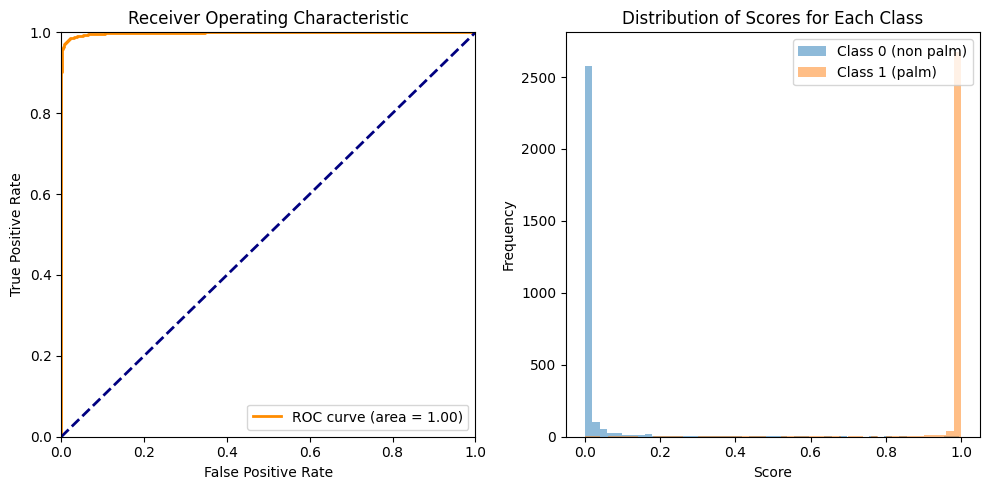

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test_int, Y_scores)
roc_auc = auc(fpr, tpr)

# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)

# Locate the optimal threshold
optimal_threshold = thresholds[ix]

print(f'Optimal Threshold based on ROC curve: {optimal_threshold}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

lw=2

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

# Scores corresponding to class 0
Y_scores_0 = Y_scores[Y_test_int==0]

# Scores corresponding to class 1
Y_scores_1 = Y_scores[Y_test_int==1]

ax2.hist(Y_scores_0, bins=50, alpha=0.5, label='Class 0 (non palm)')
ax2.hist(Y_scores_1, bins=50, alpha=0.5, label='Class 1 (palm)')
ax2.set_xlabel('Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Scores for Each Class')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

# set the maximum number of pixels to a large number
Image.MAX_IMAGE_PIXELS = 1000000000

# Open the large image
large_image_path = "/content/drive/MyDrive/Palm/FCAT2APPK.jpg"
large_image = Image.open(large_image_path)

# Define the size of the smaller images
small_image_size = (5000, 5000)

# Define the size of the patches
patch_size = (240, 240)

# Split the large image into smaller images and save them
img_counter = 0
for i in range(0, large_image.width, small_image_size[0]):
    for j in range(0, large_image.height, small_image_size[1]):
        small_image = large_image.crop((i, j, i + small_image_size[0], j + small_image_size[1]))
        small_image.save(f"/content/drive/MyDrive/Palm/small_images/small_image_{img_counter}.jpg")
        img_counter += 1


FileNotFoundError: ignored

In [24]:
img_counter=30
patch_size = (240, 240)
small_image_size = (5000, 5000)
Image.MAX_IMAGE_PIXELS = 1000000000
large_image_path = "/content/drive/MyDrive/Palm/FCAT2APPK.jpg"
large_image = Image.open(large_image_path)

In [1]:
# Import necessary module
import tensorflow as tf
import cv2

initial_image_number = 0

for i in range(initial_image_number, img_counter):
    small_image = Image.open(f"/content/drive/MyDrive/Palm/small_images/small_image_{i}.jpg")
    heatmap_array = np.zeros((small_image.height, small_image.width))

    # Iterate over the small image to get the patches
    for x in range(0, small_image.width - patch_size[0] + 1, 80):
        for y in range(0, small_image.height - patch_size[1] + 1, 80):
            # Get a patch from the small image
            patch = small_image.crop((x, y, x + patch_size[0], y + patch_size[1]))

            # Convert patch to numpy array
            patch_array = np.array(patch)

            # Check if patch contains 40% or more black or white pixels and label it as 'non palm'
            white_pixels = np.sum(patch_array > 200) / 3  # divide by 3 to account for RGB channels
            black_pixels = np.sum(patch_array <= 50) / 3
            total_pixels = patch_size[0] * patch_size[1]

            if (white_pixels + black_pixels) / total_pixels >= 0.4:
                continue  # non palm

            # If not 'non palm', extract features using ResNet18 and predict using the trained MLP
            patch = patch.resize((40, 40))

            patch_img = Image.fromarray(patch_array.astype('uint8'), 'RGB')

            # Preprocess the patch
            patch_t = preprocess_test(patch_img)
            patch_u = torch.unsqueeze(patch_t, 0)

            # Extract features
            with torch.no_grad():
                patch_features = resnet18(patch_u)

            patch_features = np.array(patch_features).reshape(1, -1)

            # Find the class with the highest probability
            class_pred = np.argmax(mlp.predict(patch_features, verbose=0), axis=1)

            # Add the prediction to the heatmap array
            heatmap_array[y:y+patch_size[1], x:x+patch_size[0]] += class_pred[0]

    # Flip the heatmap horizontally and rotate 90 degrees anticlockwise
    heatmap_array = np.flip(heatmap_array, 1)
    heatmap_array = np.rot90(heatmap_array, 1)

    # Save the heatmap array and the corresponding figure
    np.save(f"/content/drive/MyDrive/Palm/small_images/small_image_{i}_heatmap.npy", heatmap_array)

    # Repeat heatmap to match image size
    heatmap_resized = np.repeat(np.repeat(heatmap_array, 40, axis=0), 40, axis=1)

    # Convert to float32 before normalize
    heatmap_resized = heatmap_resized.astype(np.float32)

    # Create a mask from the heatmap
    mask = cv2.normalize(heatmap_resized, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)

    # Convert PIL Image to numpy array
    small_image = np.array(small_image)

    # Highlight the palms in the image using the mask
    highlighted_image = cv2.addWeighted(small_image, 0.5, cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), 0.5, 0)

    # Save the highlighted image
    cv2.imwrite(f"/content/drive/MyDrive/Palm/small_images/small_image_{i}_highlighted.jpg", highlighted_image)


NameError: ignored

## Combine the highlighted images together

In [ ]:
from PIL import Image

# Create a new image with a slightly larger size
new_image_width, new_image_height = 30000, 25000
large_image_highlighted = Image.new('RGB', (new_image_width, new_image_height))

# Specify the number of small images in each dimension
num_images_width = new_image_width // small_image_size[0]
num_images_height = new_image_height // small_image_size[1]

# Place each small image onto the large image canvas in the right order
for i in range(num_images_width):
    for j in range(num_images_height):
        small_image_highlighted = Image.open(f"/content/drive/MyDrive/Palm/small_images/small_image_{i*num_images_height + j}_highlighted.jpg")
        large_image_highlighted.paste(small_image_highlighted, (i*small_image_size[0], j*small_image_size[1]))

# Crop the combined image to the original image size
large_image_highlighted = large_image_highlighted.crop((0, 0, large_image.width, large_image.height))

# Save the resulting large image
large_image_highlighted.save("/content/drive/MyDrive/Palm/FCAT2APPK_highlighted.jpg")
